In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
import seaborn as sns
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
from warnings import simplefilter
simplefilter("ignore")

# Import et mise en forme #

In [3]:
df_source = pd.read_csv("sources/4_residus_enrichis_pour_entrainement.csv")
df_source.dtypes

Date                      object
Résidus_h                float64
rolling_mean_7           float64
rolling_stDev_7          float64
rolling_mean_25          float64
rolling_stDev_25         float64
rolling_mean_169         float64
rolling_stDev_169        float64
lag_1                    float64
lag_2                    float64
lag_3                    float64
lag_23                   float64
lag_24                   float64
lag_25                   float64
lag_26                   float64
_automne                   int64
_ete                       int64
_hiver                     int64
_printemps                 int64
_semaine                   int64
_week-end                  int64
_consommation_normale      int64
_haute_consommation        int64
dtype: object

In [4]:
# Conversion de la colonne Date de Str en DateTime
df_source["Date"] = pd.to_datetime(df_source["Date"], utc=True)\
                        .dt.tz_convert('Europe/Paris')

# Génération de Features dérivées #

In [6]:
df_features = df_source.copy()

In [7]:
df_features["l_24 x std_25"] = df_features["lag_24"] * df_features["rolling_stDev_25"]
df_features["mm_7 x std_7"] = df_features["rolling_mean_7"] * df_features["rolling_stDev_7"]
df_features["l_1 x std_7"] = df_features["lag_1"] * df_features["rolling_stDev_7"]
df_features["l_1 x mm_7"] = df_features["lag_1"] * df_features["rolling_mean_7"]
df_features["l_24 x mm_169"] = df_features["lag_24"] * df_features["rolling_mean_169"]
df_features["l_2 x mm_25"] = df_features["lag_2"] * df_features["rolling_mean_25"]
df_features["l_24 x mm_25"] = df_features["lag_24"] * df_features["rolling_mean_25"]
df_features["l_3 squared"] = df_features["lag_3"] *df_features["lag_3"]
df_features["l_26 squared"] = df_features["lag_26"] *df_features["lag_26"]

In [8]:
df_features.shape

(88223, 32)

# Split Train / Test #
Les résultats sont considérés 'Définitifs' jusqu'au 31-12-2019 inclus.<br/>
Ils sont dits "consolidés" ensuite, et donc potentiellement moins fiables car sujets à revision.<br/>
On va séparer le dataset en entraînement de Mai 2012 - Décembre 2017.<br/>
Et test de Janvier-2017 à Juin 2019<br/> (approximativement un 80/20, avec 2 hivers dans le dataset Test)

In [10]:
df_train = df_features.loc[ df_features["Date"] < "2018-01-01 00:00:00" ]
df_test = df_features.loc[ (df_features["Date"] >= "2018-01-01 00:00:00") & (df_features["Date"] < "2020-01-01 00:00:00") ]

In [16]:
print("Ratio train / Test : {:.2f} %".format((df_train.shape[0] / (df_train.shape[0] + df_test.shape[0]))*100 ) )

Ratio train / Test : 73.87 %


# Entraînement #

In [39]:
X_train = df_train.drop(columns=["Date","Résidus_h"])
X_test = df_test.drop(columns=["Date","Résidus_h"])

y_train = np.array(df_train["Résidus_h"])
y_test = np.array(df_test["Résidus_h"])


In [44]:
# Paramètres optimisés obtenu suite Hyperparameter Bayesian Search dans Dataiku
clf = LGBMRegressor(
                    boosting_type='gbdt',
                    num_leaves=272,
                    max_depth=-1,
                    learning_rate=0.1,
                    n_estimators=151,
                    subsample_for_bin=200000,
                    min_split_gain=0.432318966328,
                    min_child_weight=0.559005524338,
                    min_child_samples=34,
                    subsample=0.75,
                    subsample_freq=2,
                    colsample_bytree=1.0,
                    reg_alpha=0.423305023712,
                    reg_lambda=0.115527488401,
                    random_state=1337,
                    n_jobs=4
                  )

In [45]:
%time clf.fit(X_train, y_train)

CPU times: total: 10.5 s
Wall time: 2.75 s


LGBMRegressor(min_child_samples=34, min_child_weight=0.559005524338,
              min_split_gain=0.432318966328, n_estimators=151, n_jobs=4,
              num_leaves=272, random_state=1337, reg_alpha=0.423305023712,
              reg_lambda=0.115527488401, subsample=0.75, subsample_freq=2)

In [46]:
%time _predictions = clf.predict(X_test)
predictions = pd.Series(data=_predictions, index=X_test.index, name='Prédictions_Résidus')

CPU times: total: 688 ms
Wall time: 174 ms


In [47]:
# accuracy check
mse = mean_squared_error(y_test, predictions)
rmse = mse**(0.5)
print("RMSE: %.2f" % rmse)

RMSE: 668.32


In [37]:
def plotImp(model, X , num = 20, fig_size = (22, 20)):
    
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 2)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    #plt.savefig('lgbm_importances-01.png')
    plt.show()

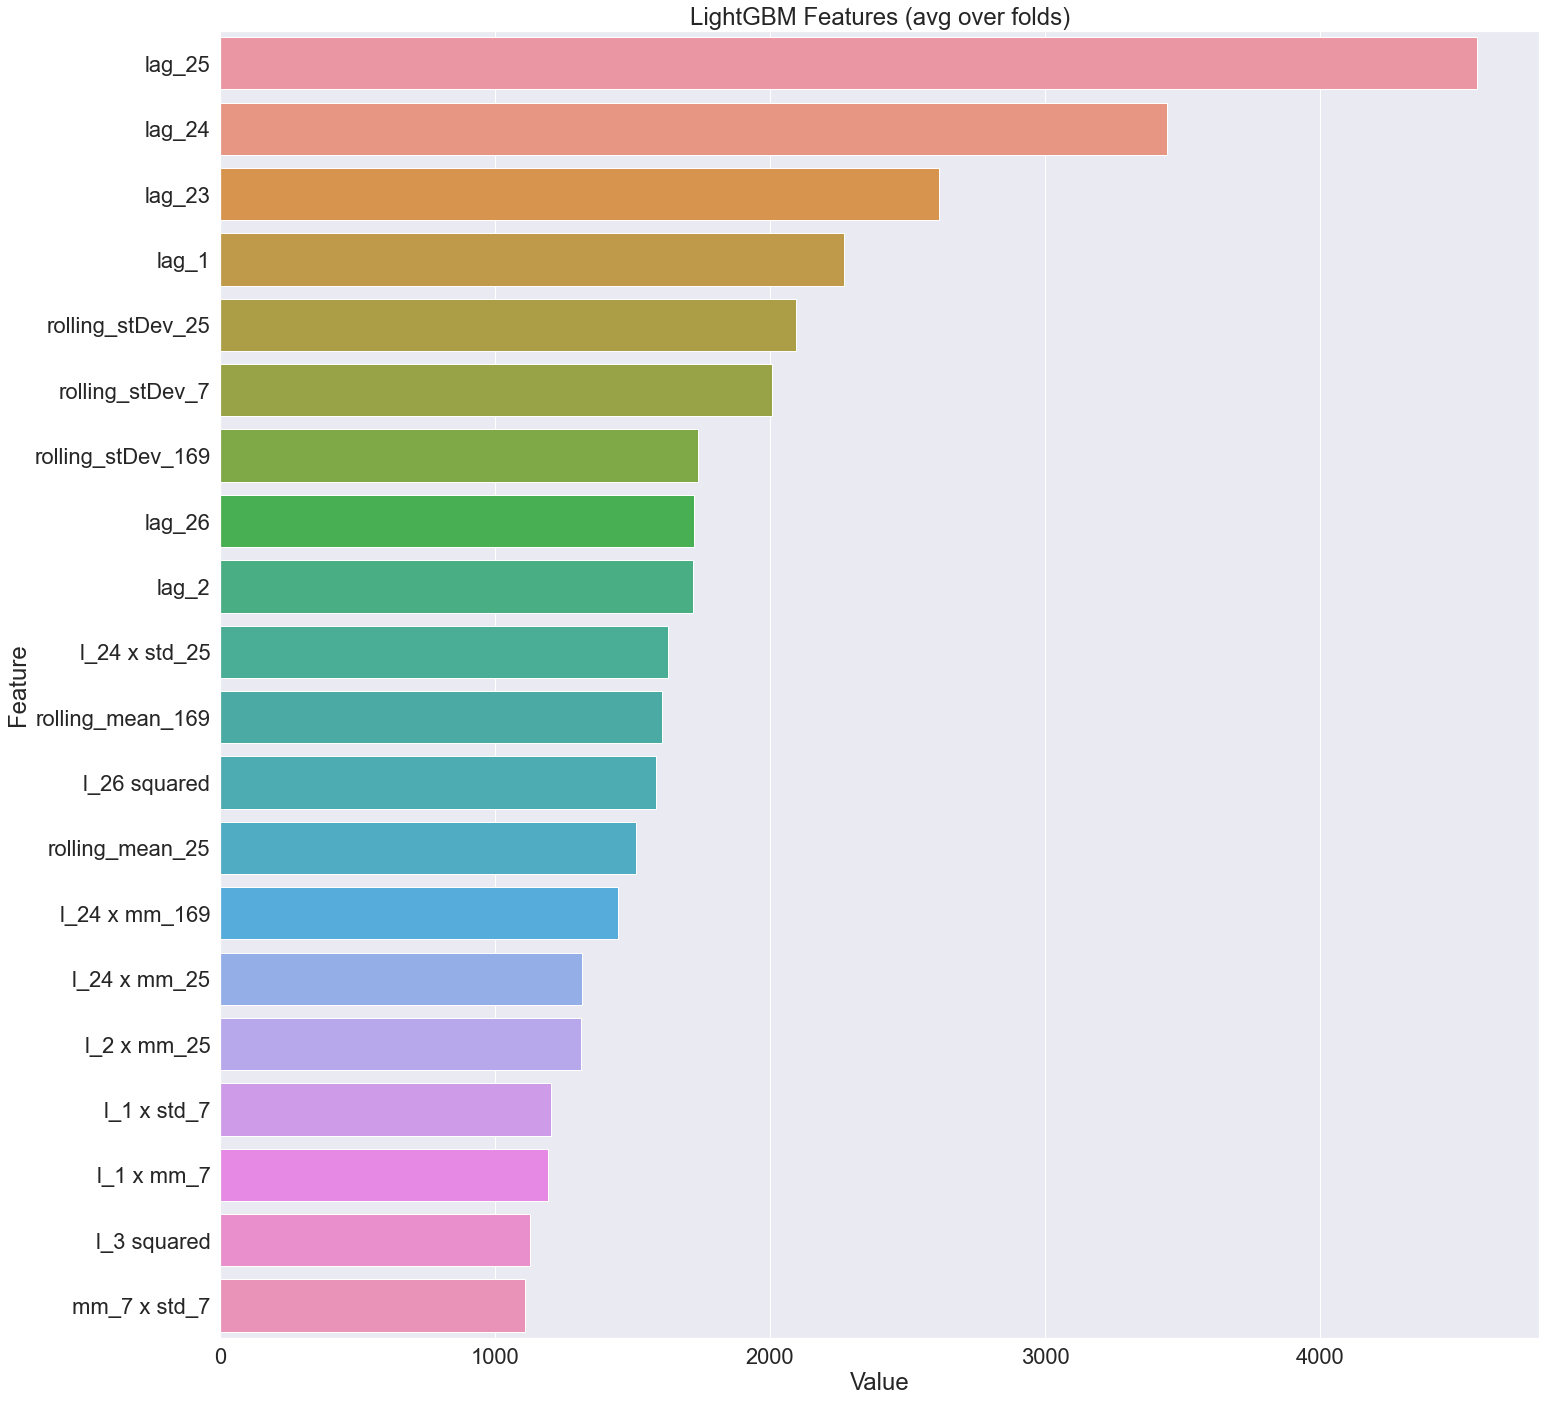

In [38]:
plotImp(clf, X_train)

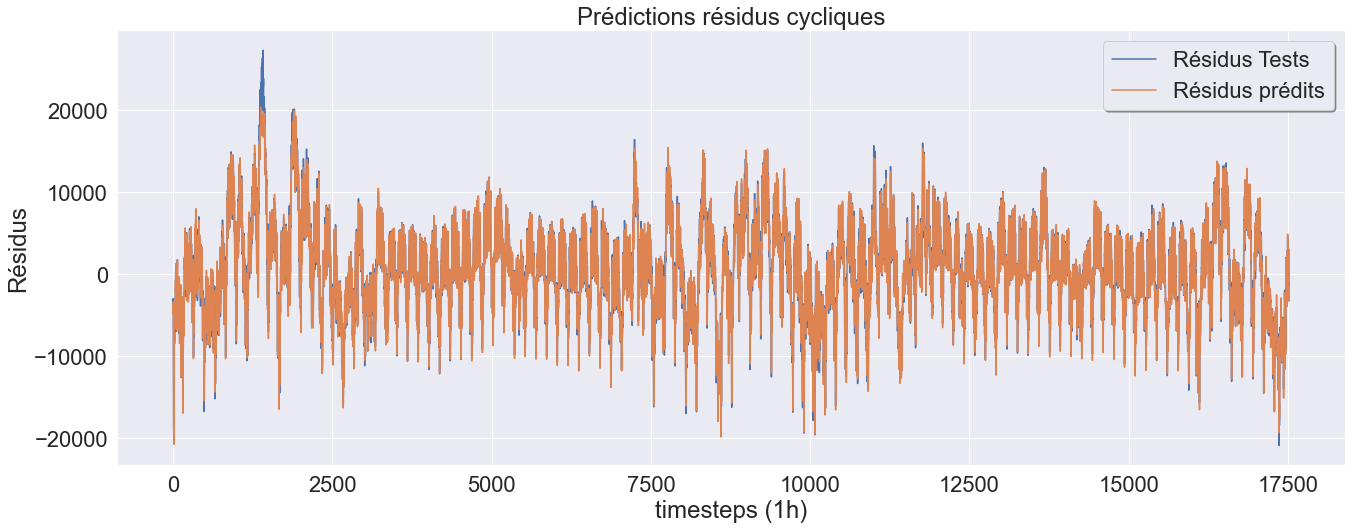

In [48]:
x_ax = range(len(y_test))
plt.figure(figsize=(22, 8))
plt.plot(x_ax, y_test, label="Résidus Tests")
plt.plot(x_ax, predictions, label="Résidus prédits")
plt.title("Prédictions résidus cycliques")
plt.xlabel('timesteps (1h)')
plt.ylabel('Résidus')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  